## Import Libraries

In [67]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from fastapi import FastAPI
from fastapi.encoders import jsonable_encoder



from sklearn import metrics

%matplotlib inline

## Load the Data

In [68]:
df = pd.read_csv("clean7")

In [69]:
df.shape

(8588, 22)

In [70]:
df.head(2)

,Unnamed: 0,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,5,Manchester United,Harry Maguire,Defender Centre-Back,194.0,30.0,68,0.037799,0.000000,0.302394,...,0.0,0.0,4762,148,27,1,25000000,70000000,2,0
1,6,Manchester United,Victor Lindelöf,Defender Centre-Back,187.0,28.0,70,0.000000,0.032901,0.115153,...,0.0,0.0,5471,95,19,10,15000000,35000000,2,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [71]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Unnamed: 0,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [72]:
# Completeness
df.isnull().sum()

Unnamed: 0             0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [73]:
# Accurecy types
df.dtypes

Unnamed: 0               int64
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [74]:
#drop the unneeded col
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['name'], axis=1)


In [75]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['team', 'position', 'position_encoded', 'winger']
numeric_features = ['height', 'age', 'appearance','goals','assists','yellow cards','second yellow cards','red cards','goals conceded','clean sheets', 'minutes played', 'days_injured', 
                    'games_injured', 'award', 'highest_value']

In [76]:
for i in categorical_features:
    print (df[i].value_counts())

team
Daejeon Hana Citizen      42
Jeonbuk Hyundai Motors    40
FC Seoul                  39
Gangwon FC                37
Swallows FC               36
                          ..
Bayern Munich              7
FC Barcelona               7
Manchester City            7
Real Madrid                6
Gaziantep FK               5
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1602
Attack Centre-Forward         1175
midfield-CentralMidfield      1011
midfield-DefensiveMidfield     804
Defender Right-Back            786
Defender Left-Back             737
midfield-AttackingMidfield     665
Attack-RightWinger             633
Attack-LeftWinger              614
Goalkeeper                     184
midfield-RightMidfield          94
midfield-LeftMidfield           92
midfield                        64
Attack-SecondStriker            53
Attack                          43
Defender                        31
Name: count, dtype: int64
position_encoded
2    3156
3    2730
4    

In [77]:
# Calculate the frequency of each 'position'
position_counts = df['position'].value_counts()

# Filter 'position' values that appear 10 or more times
df = df[df['position'].isin(position_counts[position_counts >= 2].index)]

In [78]:
# Calculate the frequency of each 'team'
team_counts = df['team'].value_counts()

# Filter 'team' values that appear 10 or more times
df = df[df['team'].isin(team_counts[team_counts >=2].index)]

In [79]:
df.shape

(8588, 20)

In [80]:
# Calculate the frequency of each 'winger'

winger_counts = df['winger'].value_counts()

# Filter 'winger' values that appear 10 or more times
df = df[df['winger'].isin(winger_counts[winger_counts >=2].index)]


In [81]:
make_counts = df['position_encoded'].value_counts()

# Filter 'position_encoded' values that appear 10 or more times
df = df[df['position_encoded'].isin(make_counts[make_counts >=2].index)]
# position_encoded

In [82]:
categorical_features

['team', 'position', 'position_encoded', 'winger']

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [83]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Centre-Back,194.0,30.0,68,0.037799,0.000000,0.302394,0.0189,0.0,0.0,0.0,4762,148,27,1,25000000,70000000,2,0
1,Manchester United,Defender Centre-Back,187.0,28.0,70,0.000000,0.032901,0.115153,0.0000,0.0,0.0,0.0,5471,95,19,10,15000000,35000000,2,0


In [84]:
categorical_features

['team', 'position', 'position_encoded', 'winger']

In [85]:
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [86]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [87]:
df.shape

(8588, 412)

In [88]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield,position_encoded_1,position_encoded_2,position_encoded_3,position_encoded_4,winger_0,winger_1
0,194.0,30.0,68,0.037799,0.000000,0.302394,0.0189,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False
1,187.0,28.0,70,0.000000,0.032901,0.115153,0.0000,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False


In [89]:
df.dtypes

height                float64
age                   float64
appearance              int64
goals                 float64
assists               float64
                       ...   
position_encoded_2       bool
position_encoded_3       bool
position_encoded_4       bool
winger_0                 bool
winger_1                 bool
Length: 412, dtype: object

In [90]:
# Calculate the 35th and 75th percentiles of the current_value
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize current_values
def categorize_current_value(current_value):
    if current_value < p35:
        return 'Cheap_current_value'
    elif current_value < p75:
        return 'Good_current_value'
    else:
        return 'High_current_value'

# Apply the function to create a new column
df['player_price_category'] = df['current_value'].apply(categorize_current_value)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_price_category'].value_counts())

player_price_category
Good_current_value     3434
Cheap_current_value    3001
High_current_value     2153
Name: count, dtype: int64


In [91]:
p35, p75

(475000.0, 3000000.0)

In [92]:
#df['car_price_category'] 

In [93]:
encoder = LabelEncoder()
df['player_price_category_encoded'] = encoder.fit_transform(df['player_price_category'])  

#### 3. Feature selection

In [94]:
# sns.heatmap(df.corr(), annot=True);

In [95]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['player_price_category_encoded'].sort_values(ascending=False))

player_price_category_encoded    1.000000
highest_value                    0.573449
appearance                       0.528099
minutes played                   0.512168
games_injured                    0.276995
                                   ...   
position_Attack                 -0.083207
position_midfield               -0.099874
position_encoded_1              -0.156813
position_Goalkeeper             -0.156813
goals conceded                        NaN
Name: player_price_category_encoded, Length: 412, dtype: float64


In [96]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_price_category_encoded']) > \
threshold]['player_price_category_encoded'].index
selected_features

Index(['appearance', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value',
       'player_price_category_encoded'],
      dtype='object')

In [97]:
selected_features =['appearance', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value',
       'player_price_category_encoded']

In [98]:
df = df[selected_features]
df.head()

,appearance,assists,minutes played,days_injured,games_injured,award,highest_value,player_price_category_encoded
0,68,0.000000,4762,148,27,1,70000000,2
1,70,0.032901,5471,95,19,10,35000000,2
2,34,0.000000,2758,47,13,0,2000000,1
3,89,0.063096,7132,182,15,3,22000000,2
4,34,0.033507,2686,175,28,1,12000000,2


#### 4. Prepare train and test data

In [99]:
# Prepare data
X = df.drop(['player_price_category_encoded'], axis=1)
y = df['player_price_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:


dict_f = {'appearance':40, 
          'assists':0.03,    
          'minutes played':4000,
          'days_injured':50,
          'games_injured':7,
          'award':1,
         
       'player_price_category_encoded':2
             }


scaler.transform(np.array([list(dict_f.values())]))

array([[ 0.11963407, -0.53155115,  0.81474978, -0.31743747, -0.29597967,
        -0.22497291, -0.55427071]])

In [101]:
json_compatible_data = jsonable_encoder(dict_f)
np.array([list(dict_f.values())])

array([[4.e+01, 3.e-02, 4.e+03, 5.e+01, 7.e+00, 1.e+00, 2.e+00]])

In [102]:
X.iloc[0,:].values

array([6.800e+01, 0.000e+00, 4.762e+03, 1.480e+02, 2.700e+01, 1.000e+00,
       7.000e+07])

In [103]:
json_compatible_data

{'appearance': 40,
 'assists': 0.03,
 'minutes played': 4000,
 'days_injured': 50,
 'games_injured': 7,
 'award': 1,
 'player_price_category_encoded': 2}

In [104]:


# dict_f = {'appearance':40, 
#           'assists':0.03,    
#           'minutes played':4000,
#           'days_injured':50,
#           'games_injured':7,
#           'award':1,
         
#        'player_price_category_encoded':2
#              }


# scaler.transform(np.array([list(dict_f.values())]))

In [105]:
json_compatible_data = jsonable_encoder(dict_f)
np.array([list(dict_f.values())])

array([[4.e+01, 3.e-02, 4.e+03, 5.e+01, 7.e+00, 1.e+00, 2.e+00]])

In [106]:
X.shape

(8588, 7)

In [107]:
X.head(2)

,appearance,assists,minutes played,days_injured,games_injured,award,highest_value
0,68,0.000000,4762,148,27,1,70000000
1,70,0.032901,5471,95,19,10,35000000


## Buliding the Model

In [108]:
model = KNeighborsClassifier()

In [109]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [110]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]}, scoring='f1_macro',
             verbose=1)

In [111]:
grid_search.best_params_

{'n_neighbors': 7}

In [112]:
model = grid_search.best_estimator_

## Test the Model

In [113]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [114]:
# our benchmark model
base_model = round(df['player_price_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

39.99

1. Accuracy

In [115]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.70023282887078

In [116]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.7678311499272198

In [117]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[417, 175,  11],
       [144, 452,  60],
       [  4, 121, 334]], dtype=int64)

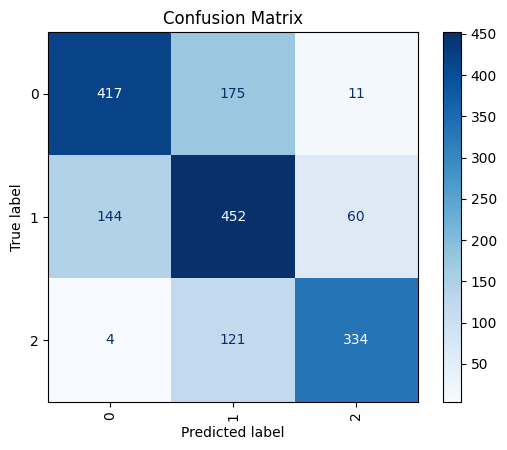

In [118]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [119]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.72


In [120]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.70


In [121]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.71


In [122]:
import joblib
joblib.dump(model, 'knn_model.joblib')
joblib.dump(scaler, 'Models/scaler.joblib')

['Models/scaler.joblib']